In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline
plt.style.use('seaborn-white')

# Problem Set 2

## Exercise 1

DGP:

* 2 classes; each classes n observations
* 2 covariates: $X_1 \sim \mathscr{N} (\mu_1, \Sigma_1)$ and $X_2 \sim \mathscr{N} (\mu_2, \Sigma_2)$
* $\mu_1 = (-3, 3)$ for class 1, $\mu_2 = (5, 5)$ for class 2, $\Sigma_1=\Sigma_2=\Sigma=
\left[ \begin{array}{ccc}
16 & -2\\
-2 & 9
\end{array} 
\right ]$
* $n_1=300$, $n_2=500$

Questions:

**a)** Generate the covariates from a multivariate normal distribution using the $\mu_k$ and $\Sigma$ as described above and
an indicator variable indicating class dependence for n observations and combine these in a data frame.

In [2]:
# Generate data.
cov = np.array([[16, -2], [-2, 9]])
def generate_data_ex1(cov1, cov2):
    """
    """
    n_11 = 300
    n_12 = 500
    n_21 = 300
    n_22 = 500

    mu_1 = np.array([-3, 3])
    mu_2 = np.array([5, 5])   

    y_1 = np.zeros(n_11 + n_12)
    y_2 = np.ones(n_21 + n_22)

    x_1 = np.random.multivariate_normal(mu_1, cov1, n_11 + n_12)
    x_2 = np.random.multivariate_normal(mu_2, cov2, n_21 + n_22)

    X = np.concatenate((x_1, x_2), axis=0)
    y = np.concatenate((y_1, y_2))
    
    return X, y

In [3]:
data_x, data_y = generate_data_ex1(cov, cov)

**b)** Calculate the linear discriminant analysis and quadratic discriminant analysis, estimating all relevant
quantities.

In [4]:
# Linear discriminant analysis.
lda = LinearDiscriminantAnalysis(solver='svd')

y_pred_linear = lda.fit(data_x, data_y).predict(data_x)

In [5]:
# Quadratic discriminant analysis.
qda = QuadraticDiscriminantAnalysis()

y_pred_quad = qda.fit(data_x, data_y).predict(data_x)

**c)** Calculate the mean training error for both methods and compare.

In [6]:
# Mean training error for both two methods
def training_error(responses, prediction):
    """
    """
    df_temp = pd.DataFrame({
        'True responses': responses,
        'Predicted responses': prediction
    })
    df_temp.replace(to_replace={0: 'class 1', 1: 'class 2'}, inplace=True)
    df_confusion = df_temp.groupby(['True responses', 'Predicted responses']).size().unstack('True responses')

    cor_c1 = df_confusion['class 1'][0]
    cor_c2 = df_confusion['class 2'][1]
    wr_c12 = df_confusion['class 1'][1]
    wr_c21 = df_confusion['class 2'][0]

    error_c12 = wr_c12 / (cor_c1 + wr_c12)
    error_c21 = wr_c21 / (cor_c2 + wr_c21)
    error_mean = np.mean([error_c12, error_c21])

    error = pd.Series(data={'class 1': error_c12, 
                            'class 2': error_c21,
                            'mean': error_mean}).to_frame().T
    
    return df_confusion, error

In [7]:
lda_mean_error = training_error(data_y, y_pred_linear)[1].iloc[0]['mean']
qda_mean_error = training_error(data_y, y_pred_quad)[1].iloc[0]['mean']

In [8]:
print('lda_mean_error - qda_mean_error = {:.7f}'.format(lda_mean_error - qda_mean_error))

lda_mean_error - qda_mean_error = 0.0025000


## Exercise 2

**a)** Evaluate the difference between the two methods through calculating classification training error in a
simulation study for 100 different samples.

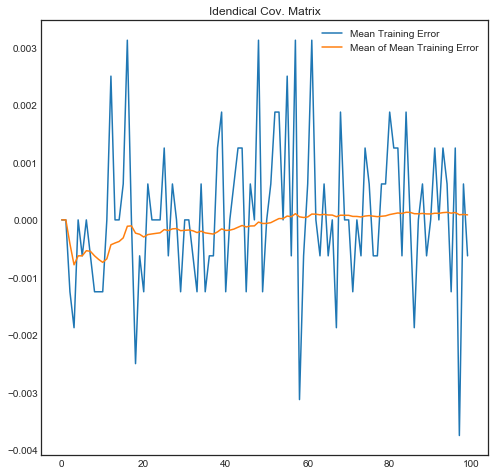

In [9]:
# Simulate 100 times.
sim = 100

diff_list = []
ave_diff_list = []
for i in range(sim):
    x_train, y_true = generate_data_ex1(cov, cov)
    y_pred_linear_sim = lda.fit(x_train, y_true).predict(x_train)
    y_pred_quad_sim = qda.fit(x_train, y_true).predict(x_train)

    lda_mean_error_sim = training_error(y_true, y_pred_linear_sim)[1].iloc[0]['mean']
    qda_mean_error_sim = training_error(y_true, y_pred_quad_sim)[1].iloc[0]['mean']
    diff_sim = lda_mean_error_sim - qda_mean_error_sim

    diff_list.append(diff_sim)
    ave_diff_list.append(np.mean(diff_list))

# Plot the simulation results.
fig1, ax1 = plt.subplots(figsize=(8, 8))

ax1.plot(diff_list, color='C0', label='Mean Training Error')
ax1.plot(ave_diff_list, color='C1', label='Mean of Mean Training Error')
ax1.set_title('Idendical Cov. Matrix')
ax1.legend()

**b)** Consider the theoretical properties of lda and qda that we discussed in the lecture: Which properties of the
initial simulation set up could we manipulate in order to increase the difference between the classification
error of lda and qda? Test your intuition by performing a suitable simulation study.



We generate different covariance matrix for each simulation by randomly drawing integers for the elements in the matrices. The intergers vary in large intervals. It's obvious that the lda method becomes significantly worse off.

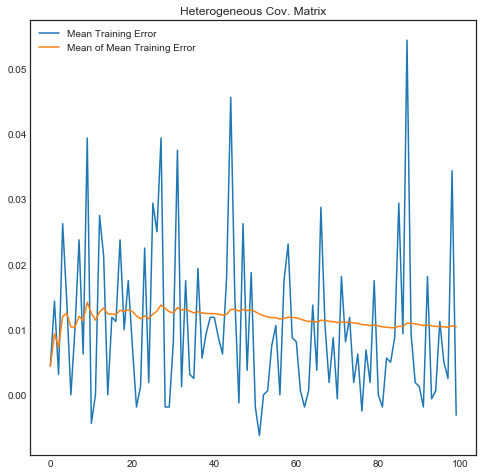

In [11]:
# Redo the simulation and the plot.
diff_list = []
ave_diff_list = []
for i in range(sim):
    # Different covariance matices.
    v11 = np.random.randint(3, 30, size=2)
    v12 = np.random.randint(-5, 5, size=2)
    v22 = np.random.randint(3, 30, size=2)
    cov1 = np.array([[v11[0], v12[0]], [v12[0], v22[0]]])
    cov2 = np.array([[v11[1], v12[1]], [v12[1], v22[1]]])    
    
    x_train, y_true = generate_data_ex1(cov1, cov2)
    y_pred_linear_sim = lda.fit(x_train, y_true).predict(x_train)
    y_pred_quad_sim = qda.fit(x_train, y_true).predict(x_train)

    lda_mean_error_sim = training_error(y_true, y_pred_linear_sim)[1].iloc[0]['mean']
    qda_mean_error_sim = training_error(y_true, y_pred_quad_sim)[1].iloc[0]['mean']
    diff_sim = lda_mean_error_sim - qda_mean_error_sim

    diff_list.append(diff_sim)
    ave_diff_list.append(np.mean(diff_list))
    
# Plot the simulation results.
fig2, ax2 = plt.subplots(figsize=(8, 8))

ax2.plot(diff_list, color='C0', label='Mean Training Error')
ax2.plot(ave_diff_list, color='C1', label='Mean of Mean Training Error')
ax2.set_title('Heterogeneous Cov. Matrix')
ax2.legend()